Hi guys, after studying multiple notebooks, blog posts I am building a machine learning model 

In [408]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Let's load the train and test set into a pandas dataframe using pandas's read_csv function.
The head funtion gives presents the top 🔝 few rows.

In [409]:
train_df = pd.read_csv('../input/titanic/train.csv') 
test_df = pd.read_csv('../input/titanic/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now the next step is to understand the data, for example 
1. what are the features, 
2. what kind of transformations are needed yo be done on those features (normalization, one-hot encoding for categorical features, etc) , 
3. missing data if any and 
4. best ways to impute missing data

There are multiple ways to achieve this. One can use df.describe() or df.info() or even [pandas-profiling library](https://github.com/pandas-profiling/pandas-profiling)
But here I have built my own code block to get this done. 

In [410]:
target_col = 'Survived'

print(f"Shape of dataframe {train_df.shape}")

rows = []
for col in train_df.columns: # iterate through each column
    if train_df[col].isin([0, 1, np.nan]).all(): # if column is binary, print binary as data type, number of missing values and correlation with target
        row_dict = {'ColumnName': col, 'DataType': 'binary', 'HasMissing':train_df.isnull().any().loc[col],
                    'NumberOfMissingCells': train_df.isnull().sum().loc[col], 'CorrelationWithTarget': train_df.corr()[target_col].loc[col],
                    'Mean': np.nan, 'Median': np.nan,'Mode': train_df.mode()[col].loc[0], 'MinValue': np.nan, 'MaxValue': np.nan }
    
    elif train_df.dtypes.loc[col] == 'int64' or train_df.dtypes.loc[col] == 'float64': # if column is continous, then print Number Of MissingCells, Correlation With Target, mean, median, mode, Min and Max
        
        row_dict = {'ColumnName': col, 'DataType': train_df.dtypes.loc[col], 'HasMissing':train_df.isnull().any().loc[col],
                    'NumberOfMissingCells': train_df.isnull().sum().loc[col], 'CorrelationWithTarget': train_df.corr()[target_col].loc[col],
                    'Mean': train_df.mean().loc[col], 'Median':train_df.median().loc[col], 'Mode': train_df.mode()[col].loc[0],
                    'MinValue': train_df.min().loc[col], 'MaxValue': train_df.max().loc[col] }
        
    else: # finally if column is categorical, print only NumberOfMissingCells and mode (most frequent values)
        row_dict = {'ColumnName': col, 'DataType': train_df.dtypes.loc[col], 'HasMissing':train_df.isnull().any().loc[col],
                    'NumberOfMissingCells': train_df.isnull().sum().loc[col], 'CorrelationWithTarget': np.nan, 'Mean': np.nan, 'Median': np.nan,
                    'Mode': train_df.mode()[col].loc[0], 'MinValue': np.nan, 'MaxValue': np.nan }
        
    rows.append(row_dict)
    
        
info_df = pd.DataFrame(rows, columns=['ColumnName', 'DataType', 'HasMissing', 'NumberOfMissingCells', 'CorrelationWithTarget', 'Mean', 'Median', 'Mode', 'MinValue', 'MaxValue'])

info_df.set_index('ColumnName', inplace=True)
    
info_df = info_df.sort_values('CorrelationWithTarget', ascending=False, na_position='last')

print("FOR NUMERICAL COLUMNS")
info_df[info_df['DataType']!='object']

Shape of dataframe (891, 12)
FOR NUMERICAL COLUMNS


,DataType,HasMissing,NumberOfMissingCells,CorrelationWithTarget,Mean,Median,Mode,MinValue,MaxValue
ColumnName,,,,,,,,,
Survived,binary,False,0,1.000000,NaN,NaN,0,NaN,NaN
Fare,float64,False,0,0.257307,32.204208,14.4542,8.05,0.00,512.3292
Parch,int64,False,0,0.081629,0.381594,0.0000,0,0.00,6.0000
PassengerId,int64,False,0,-0.005007,446.000000,446.0000,1,1.00,891.0000
SibSp,int64,False,0,-0.035322,0.523008,0.0000,0,0.00,8.0000
Age,float64,True,177,-0.077221,29.699118,28.0000,24,0.42,80.0000
Pclass,int64,False,0,-0.338481,2.308642,3.0000,3,1.00,3.0000


The remaining columns are categorical in nature and we will analyse the correlation with target one by one.

In [411]:
print("\nFor categorical/non-numeric columns")
info_df[info_df['DataType']=='object'].drop(['CorrelationWithTarget', 'Mean', 'Median', 'MinValue', 'MaxValue'], axis=1)


For categorical/non-numeric columns


,DataType,HasMissing,NumberOfMissingCells,Mode
ColumnName,,,,
Name,object,False,0,"Abbing, Mr. Anthony"
Sex,object,False,0,male
Ticket,object,False,0,1601
Cabin,object,True,687,B96 B98
Embarked,object,True,2,S


In [412]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Observations:

1. Columns Cabin, Embarked and Age have missing data in training set.
2. Most common value of Embarked is S
3. Fare has the highest correlation with Survived


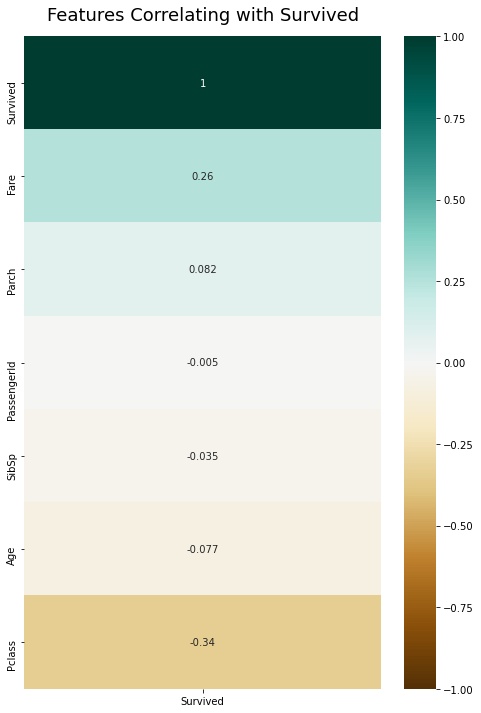

In [413]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_df.corr()[[target_col]].sort_values(by=target_col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Features Correlating with {target_col}', fontdict={'fontsize':18}, pad=16);

# Name
Starting with the name column, it does not direcly contribute to the survival of a person, but it contains the title.
The title of a person tells us how important he/she is. An important person like the Royalty are more likely to be rescued first.
We can see below that there are many title, so lets combine them into more meaningful categories. For example Master refers you male children and 'Mlle' or 'Ms' means 'Miss' .

In [414]:
train_df.Name.str.split(',').str[1].str.split('.').str[0].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 Capt              1
 Lady              1
 Mme               1
 Ms                1
 the Countess      1
 Don               1
 Sir               1
 Jonkheer          1
Name: Name, dtype: int64

In [415]:
train_df['Title'] = train_df.Name.str.split(',').str[1].str.split('.').str[0].str.strip() # create the title column
test_df['Title'] = test_df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()

# anything other than Mr, Mrs, Miss and Master will be kept in others group
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

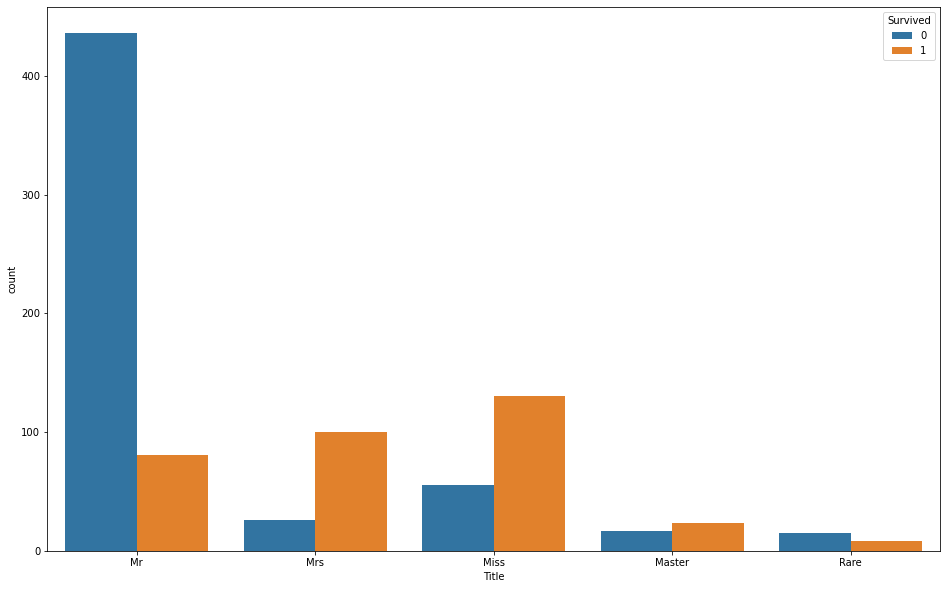

In [416]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
sns.countplot(x="Title", hue="Survived", data=train_df)

We can observer that women and children have survived more than other groups
Now let's transform these using label encoder.

In [417]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values('Survived')

,Title,Survived
2,Mr,0.156673
4,Rare,0.347826
0,Master,0.575000
1,Miss,0.702703
3,Mrs,0.793651


In [418]:
train_df.Title = train_df.Title.map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
test_df.Title = test_df.Title.map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

# Sex
There re no missing values as before, but we need to convert this categorical to numeric (binary) for feeding to our algorithm.

In [419]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

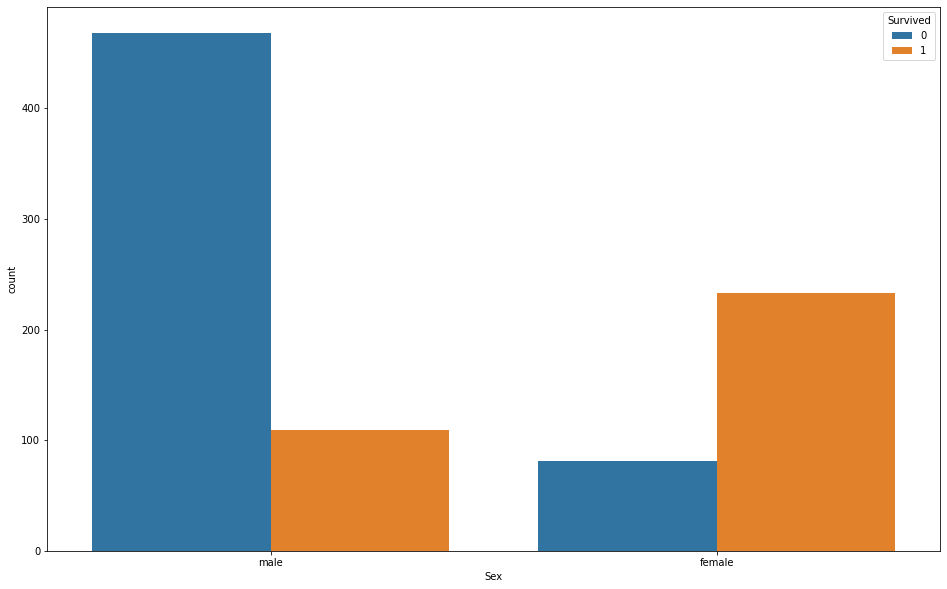

In [420]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
sns.countplot(x="Sex", hue="Survived", data=train_df)

In [421]:
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

In [422]:
train_df['Sex'].unique()

array([0, 1])

# Ticket
This is the ticket number of a pasenger. It is an alphanumeric feature and may not be related to Survival. Also it has many too unique values 681 out of 891
So we will drop it.

In [423]:
print(f"Ticket column  has {len(train_df.Ticket.unique())} unique alphanumeric values out of {len(train_df.Ticket)}")

Ticket column  has 681 unique alphanumeric values out of 891


# Cabin
This feature 
This is also an alphanumeric column and it has lots of missing data, 687 out of 891 to be excact. It would not be a good idea to keep this.
So we will drop it.

In [424]:
print(f"Cabin column  has {len(train_df.Cabin.unique())} unique alphanumeric values out of {len(train_df.Cabin)}")

Cabin column  has 148 unique alphanumeric values out of 891


# Embarked

Tells us the port at which a passenger got on the ship.
C = Cherbourg, Q = Queenstown, S = Southampton
This feature has 2 missing values. We can replace this by most common value S. But let's investigate first

In [425]:
train_df[train_df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,3


In both the cases, the passengers are females, of Pclass value 1 and have survived. They also have paid same fare and are in same cabin. This is intresting.
But other than that there seems no way to know the embarked value.

In [426]:
test_df[test_df.Embarked.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [427]:
# replacing na with S
train_df.Embarked = train_df.Embarked.fillna('S')

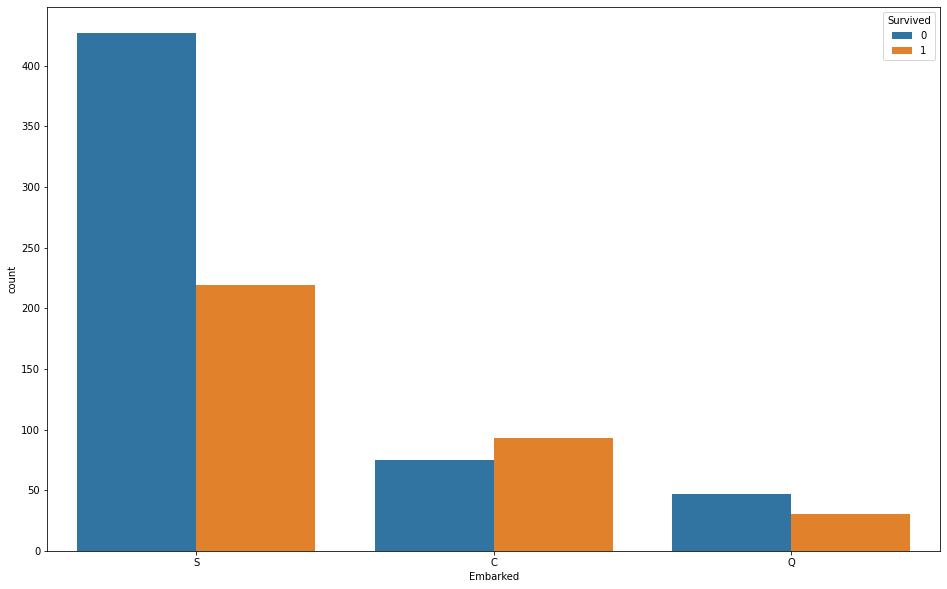

In [428]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
sns.countplot(x="Embarked", hue="Survived", data=train_df)

In [429]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values('Survived')

,Embarked,Survived
2,S,0.339009
1,Q,0.389610
0,C,0.553571


In [430]:
train_df.Embarked = train_df.Embarked.map({'S': 0, 'C': 1, 'Q': 2})
test_df.Embarked = test_df.Embarked.map({'S': 0, 'C': 1, 'Q': 2})

# Fare
1 missing in test_df, Highest correlation

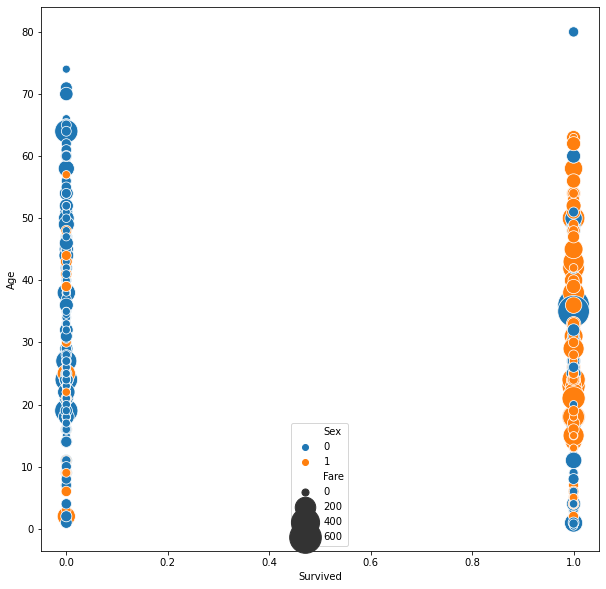

In [431]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
sns.scatterplot(data=train_df, x="Survived", y="Age", hue="Sex", size="Fare", sizes=(50,1000))


Conclusions that can be drawn from this scatter plot:
1. There are more orange circles in survived section-> More females survived than males
2. The size of the circles in the survived column are comparatively larger than the ones in the not-survived column. Larger circle->larger fare. So people withe more fare are more likely to survive

In [432]:
test_df[test_df.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,0,1


In [433]:
train_df[(train_df.Pclass==3) & (train_df.Title==1) & (train_df.Embarked==0) & (train_df.Age>=60)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
326,327,0,3,"Nysveen, Mr. Johan Hansen",0,61.0,0,0,345364,6.2375,NaN,0,1
851,852,0,3,"Svensson, Mr. Johan",0,74.0,0,0,347060,7.7750,NaN,0,1


In [434]:
train_df[(train_df.Pclass==3) & (train_df.Title==1) & (train_df.Embarked==0) & (train_df.Age>=50)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
94,95,0,3,"Coxon, Mr. Daniel",0,59.0,0,0,364500,7.2500,NaN,0,1
152,153,0,3,"Meo, Mr. Alfonzo",0,55.5,0,0,A.5. 11206,8.0500,NaN,0,1
222,223,0,3,"Green, Mr. George Henry",0,51.0,0,0,21440,8.0500,NaN,0,1
326,327,0,3,"Nysveen, Mr. Johan Hansen",0,61.0,0,0,345364,6.2375,NaN,0,1
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",0,51.0,0,0,347064,7.7500,NaN,0,1
482,483,0,3,"Rouse, Mr. Richard Henry",0,50.0,0,0,A/5 3594,8.0500,NaN,0,1
631,632,0,3,"Lundahl, Mr. Johan Svensson",0,51.0,0,0,347743,7.0542,NaN,0,1
851,852,0,3,"Svensson, Mr. Johan",0,74.0,0,0,347060,7.7750,NaN,0,1


An intresting thing to note is that for passengers with age greater than 60 (or even 50) years, where the Pclass, title, sex, embarked is same as the person with missing data. So it would be a wiser shoice to impute this using mean from this group rather than mean fare of whole dataset. 

In [435]:
mean_fare_grp = train_df[(train_df.Pclass==3) & (train_df.Title==1) & (train_df.Embarked==0) & (train_df.Age>=50)].Fare.mean()

In [436]:
test_df.Fare = test_df.Fare.fillna(mean_fare_grp)

In [437]:
train_df[train_df.Ticket=='LINE']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
179,180,0,3,"Leonard, Mr. Lionel",0,36.0,0,0,LINE,0.0,NaN,0,1
271,272,1,3,"Tornquist, Mr. William Henry",0,25.0,0,0,LINE,0.0,NaN,0,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",0,19.0,0,0,LINE,0.0,NaN,0,1
597,598,0,3,"Johnson, Mr. Alfred",0,49.0,0,0,LINE,0.0,NaN,0,1


So there are four cases with zero fare. I don't know how that is possible. May be they were in the waiting line..?
But one of them survived. Moving on..

# Parch and SibSp
A combination of both can give the family size

In [438]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df['isAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'isAlone'] = 1
test_df['isAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'isAlone'] = 1


In [439]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,isAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,3,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,3,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,1


In [440]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,isAlone
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,3,2,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2,1,1,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,3,3,0


# Age 
We will create age bands using the age data, but first we need to impute missing data

In [441]:
grouped_train = train_df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train.head()

,Sex,Pclass,Title,Age
0,0,1,1,40.0
1,0,1,4,4.0
2,0,1,5,49.0
3,0,2,1,31.0
4,0,2,4,1.0


In [442]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


train_df['Age'] = train_df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
test_df['Age'] = test_df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)

In [443]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df.AgeBand.value_counts()

(16.336, 32.252]    490
(32.252, 48.168]    216
(0.34, 16.336]      104
(48.168, 64.084]     70
(64.084, 80.0]       11
Name: AgeBand, dtype: int64

In [444]:
train_df.loc[train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[train_df['Age'] > 64, 'Age'] = 4

test_df.loc[train_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(train_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(train_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(train_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[train_df['Age'] > 64, 'Age'] = 4

In [445]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

train_df.loc[ train_df['Fare'] <= 7.91, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare']   = 2
train_df.loc[ train_df['Fare'] > 31, 'Fare'] = 3
train_df['Fare'] = train_df['Fare'].astype(int)

test_df.loc[ test_df['Fare'] <= 7.91, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.91) & (test_df['Fare'] <= 14.454), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 14.454) & (test_df['Fare'] <= 31), 'Fare']   = 2
test_df.loc[ test_df['Fare'] > 31, 'Fare'] = 3
test_df['Fare'] = test_df['Fare'].astype(int)


In [446]:
train_df['Age*Class'] = train_df.Age * train_df.Pclass
test_df['Age*Class'] = test_df.Age * test_df.Pclass

In [447]:
train_df.drop(['SibSp', 'Parch', 'FamilySize', 'PassengerId', 'Cabin', 'PassengerId', 'Name', 'Ticket', 'AgeBand', 'FareBand'], axis=1, inplace=True)
test_df.drop(['SibSp', 'Parch', 'FamilySize', 'PassengerId', 'Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [448]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1.0,0,0,1,0,3.0
1,1,1,1,2.0,3,1,3,0,2.0
2,1,3,1,1.0,1,0,2,1,3.0
3,1,1,1,2.0,3,0,3,0,2.0
4,0,3,0,2.0,1,0,1,1,6.0


In [449]:
import warnings
warnings.filterwarnings('ignore')

logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()
gnb = GaussianNB()
svm = SVC()
knn = KNeighborsClassifier()
xgboost = XGBClassifier()
dc = DecisionTreeClassifier()
adc = AdaBoostClassifier()
models = [logreg, logreg_cv, rf, gboost, gnb, svm, knn, xgboost, dc, adc]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_df.drop('Survived', axis=1), y=train_df['Survived'], scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8024919967359236
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.7913188123783818
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8036155922415416
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8103320569957944
****
Cross-validation of : <class 'sklearn.naive_bayes.GaussianNB'>
CV score = 0.7644027368024606
****
Cross-validation of : <class 'sklearn.svm._classes.SVC'>
CV score = 0.8147824995292197
****
Cross-validation of : <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
CV score = 0.8025296591551063
****
Cross-validation of : <class 'xgboost.sklearn.XGBClassifier'>
CV score = 0.8103446111355218
****
Cross-validation of : <class 'sklearn.tree._classes.DecisionTreeClassifier'>
CV score = 0.7946393823363254
****
Cross-validat

In [450]:
clf = AdaBoostClassifier()
clf.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

y_pred = clf.predict(test_df)

test_df2 = pd.read_csv('../input/titanic/test.csv')

submission = pd.DataFrame({
        "PassengerId": test_df2["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('submission_ada.csv', index=False)

In [451]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

parameter_grid = {
                 'max_depth' : [4, 6, 8, 10],
                 'n_estimators': [50, 30, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 6, 10],
                 'min_samples_leaf': [1, 3, 5, 10],
                 'bootstrap': [True, False],
                 }
forest = RandomForestClassifier()
cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1, n_jobs=-1
                              )

grid_search.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
model = grid_search
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
    

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.816, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.827, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.758, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.788, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.820, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.798, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.821, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30, score=0.777, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30, score=0.803, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=30 


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.764, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10, score=0.838, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, score=0.792, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, score=0.815, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, score=0.747, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=10, score=0.848, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50 


[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=0.799, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30, score=0.793, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=10, min_samples_split=6, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.747, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.804, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=10, score=0.826, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=10, score=0.758, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=10, score=0.848, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.810, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5

[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50, score=0.793, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50, score=0.803, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=50 


[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.827, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.803, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=10, score=0.810, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=10 


[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10, score=0.848, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10, score=0.787, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=10, score=0.831, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.804, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.803, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=6, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.827, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 


[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=30, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=30, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, score=0.821, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10 


[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.798, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.826, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.798, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.837, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=50 


[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, score=0.827, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.821, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=30 


[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.843, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=10, score=0.816, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=10, score=0.775, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=10, score=0.820, total=   0.0s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=50, score=0.804, total=   0.1s
[CV] bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.799, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.787, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=30, score=0.799, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=30, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=30 


[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=10 


[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.804, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.792, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=10 


[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.782, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=50 


[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.843, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.793, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=30, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.787, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.843, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=10, score=0.804, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.815, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.758, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=30 


[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10 


[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.816, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.781, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=10 


[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.815, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.787, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.826, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50, score=0.816, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=50 


[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.764, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=3, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.804, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.787, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.815, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.810, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.787, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50 


[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, score=0.865, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.788, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.775, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=30 


[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=10, score=0.765, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=10 


[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.787, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.843, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.775, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.831, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=50 


[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.804, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.764, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.821, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimators=30, score=0.803, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=3, n_estimat

[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=10, score=0.793, total=   0.0s
[CV] bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, score=0.775, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, score=0.798, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, score=0.781, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=10, score=0.854, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 


[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50, score=0.799, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50, score=0.764, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50 


[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.782, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.775, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=30 


[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.788, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10 


[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10, score=0.764, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10, score=0.826, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10, score=0.798, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=10, score=0.848, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50 

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.827, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.826, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.764, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, n_estimat

[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.804, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.787, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10, score=0.804, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=10 


[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, score=0.775, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, score=0.831, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, score=0.781, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, score=0.837, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimato

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.782, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50 


[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.799, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.775, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=30 


[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.770, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.815, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.854, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=10 


[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.788, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.770, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.809, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimat

[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.816, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.809, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, min_samples_split=10, n

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=50, score=0.848, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.793, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=30 


[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, score=0.792, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10, score=0.832, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimat

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10, score=0.775, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10, score=0.831, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10, score=0.781, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=10, score=0.837, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=50 


[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.788, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.758, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.820, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50 


[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=50, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.793, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.781, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30, score=0.837, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=5, min_samples_split=6, n_estimators=30 


[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=30, score=0.831, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.788, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.815, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=0.820, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimat

[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=10, score=0.803, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=10 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=10, score=0.843, total=   0.0s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.804, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.798, total=   0.1s
[CV] bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_es

KeyboardInterrupt: 

In [ ]:
parameter_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

forest = GradientBoostingClassifier()
cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1, n_jobs=-1
                              )

grid_search.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
model = grid_search
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
    

Fitting 5 folds for each of 84672 candidates, totalling 423360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 6060 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 9660 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 14060 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 19260 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 25260 tasks      | elapsed:  2.4min
